In [43]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import subprocess
import re

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [132]:
major_set = '../swan/isos_sample_gene_90.tsv'
c_annot = 'cerberus_annot_triplets.h5'
gtf = '../cerberus.gtf'
swan_file = '../swan/swan.p'
filt_ab = '../cerberus_filtered_abundance.tsv'
h5 = '../cerberus_annot.h5'

## Get # isoforms in a sample for a given gene in the major set

In [55]:
major_set_df = pd.read_csv(major_set, sep='\t')

In [56]:
df = major_set_df[['tid', 'gname', 'gid', 'sample']]
df = df.groupby(['gname', 'gid', 'sample']).count().reset_index()
df.rename({'tid': 'n_tid'}, axis=1, inplace=True)

In [1]:
# df.loc[df.gname == 'ELN']

In [44]:
# df.loc[(df.gname == 'CTCF')&(df.n_tid >= 5)]

## Get # TSSs in a sample for a given gene in the major set

In [47]:
major_set_df = pd.read_csv(major_set, sep='\t')

In [49]:
major_set_df = add_feat(major_set_df, kind='tss', col='tid')

In [51]:
df = major_set_df[['tss', 'gname', 'gid', 'sample']]
df = df.groupby(['gname', 'gid', 'sample']).nunique().reset_index()
df.rename({'tss': 'n_tss'}, axis=1, inplace=True)

In [54]:
df.loc[(df.gname == 'CTCF')&(df.n_tss == 4)]

,gname,gid,sample,n_tss
152862,CTCF,ENSG00000102974.15,gm12878,4
152870,CTCF,ENSG00000102974.15,h9_panc_beta,4
152880,CTCF,ENSG00000102974.15,hl60_m1_72hr,4
152883,CTCF,ENSG00000102974.15,hl60_m2_72hr,4
152902,CTCF,ENSG00000102974.15,vessels,4


In [62]:
temp = major_set_df.loc[(major_set_df.gname=='CTCF')&(major_set_df['sample'] == 'vessels')].copy(deep=True)
temp = add_feat(temp, kind='tss', col='tid')

In [64]:
tsss = temp.tss.tolist()

In [68]:
ca = cerberus.read(c_annot)

In [76]:
tss = pr.PyRanges(ca.tss)
tss.to_bed('cerberus_tss.bed')

tss_map = pr.PyRanges(ca.tss_map)
tss_map.to_bed('cerberus_tss_map.bed')

In [71]:
ca.tss.loc[ca.tss.Name.isin(tsss)]

,Chromosome,Start,End,Strand,Name,source,novelty,gene_id,tss
112371,chr16,67562416,67562639,+,ENSG00000102974_1,"v40,v29,lapa,gtex,encode_cage,fantom_cage,pls",Known,ENSG00000102974,1
112372,chr16,67626458,67626559,+,ENSG00000102974_10,"v40,v29,lapa,dels",Known,ENSG00000102974,10
112376,chr16,67610539,67610640,+,ENSG00000102974_3,"v40,v29,lapa",Known,ENSG00000102974,3
112382,chr16,67620836,67620937,+,ENSG00000102974_9,"v40,v29,lapa",Known,ENSG00000102974,9


In [75]:
ca.tss_map.loc[ca.tss_map.Name.isin(tsss)].sort_values(by='Name')

,Chromosome,Start,End,Strand,source,Name
1910538,chr16,67562416,67562639,+,v40,ENSG00000102974_1
1932191,chr16,67562595,67562617,+,fantom_cage,ENSG00000102974_1
1932190,chr16,67562514,67562594,+,fantom_cage,ENSG00000102974_1
1932189,chr16,67562481,67562508,+,fantom_cage,ENSG00000102974_1
1920551,chr16,67562356,67562639,+,v29,ENSG00000102974_1
1932188,chr16,67562453,67562464,+,fantom_cage,ENSG00000102974_1
1932187,chr16,67562433,67562450,+,fantom_cage,ENSG00000102974_1
1928129,chr16,67562465,67562721,+,encode_cage,ENSG00000102974_1
1924721,chr16,67562232,67562662,+,lapa,ENSG00000102974_1
1926877,chr16,67562487,67562588,+,gtex,ENSG00000102974_1


In [82]:
ca.t_map.loc[(ca.t_map.tss_id.isin(tsss))&(ca.t_map.source != 'lapa')].sort_values(by='tss_id')

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue,source
81328,ENST00000264010.10,1,ENSG00000102974_1,ENSG00000102974_1,1,ENSG00000102974_1,1,ENSG00000102974,CTCF,CTCF-201,"[1,1,1]","ENSG00000102974[1,1,1]","CTCF[1,1,1]",False,False,v40
81886,ENST00000401394.6,7,ENSG00000102974_7,ENSG00000102974_1,1,ENSG00000102974_1,1,ENSG00000102974,CTCF,CTCF-202,"[1,7,1]","ENSG00000102974[1,7,1]","CTCF[1,7,1]",False,False,v40
86576,ENST00000644852.1,9,ENSG00000102974_9,ENSG00000102974_1,1,ENSG00000102974_2,2,ENSG00000102974,CTCF,CTCF-210,"[1,9,2]","ENSG00000102974[1,9,2]","CTCF[1,9,2]",False,False,v40
86606,ENST00000646076.1,2,ENSG00000102974_2,ENSG00000102974_1,1,ENSG00000102974_1,1,ENSG00000102974,CTCF,CTCF-215,"[1,2,1]","ENSG00000102974[1,2,1]","CTCF[1,2,1]",False,False,v40
86630,ENST00000646771.1,6,ENSG00000102974_6,ENSG00000102974_1,1,ENSG00000102974_1,1,ENSG00000102974,CTCF,CTCF-217,"[1,6,1]","ENSG00000102974[1,6,1]","CTCF[1,6,1]",False,False,v40
68664,ENST00000264010.9,1,ENSG00000102974_1,ENSG00000102974_1,1,ENSG00000102974_1,1,ENSG00000102974,CTCF,CTCF-201,"[1,1,1]","ENSG00000102974[1,1,1]","CTCF[1,1,1]",False,False,v29
69233,ENST00000401394.6,7,ENSG00000102974_7,ENSG00000102974_1,1,ENSG00000102974_1,1,ENSG00000102974,CTCF,CTCF-202,"[1,7,1]","ENSG00000102974[1,7,1]","CTCF[1,7,1]",False,False,v29
73976,ENST00000644852.1,9,ENSG00000102974_9,ENSG00000102974_1,1,ENSG00000102974_2,2,ENSG00000102974,CTCF,CTCF-210,"[1,9,2]","ENSG00000102974[1,9,2]","CTCF[1,9,2]",False,False,v29
74007,ENST00000646076.1,2,ENSG00000102974_2,ENSG00000102974_1,1,ENSG00000102974_1,1,ENSG00000102974,CTCF,CTCF-215,"[1,2,1]","ENSG00000102974[1,2,1]","CTCF[1,2,1]",False,False,v29
74032,ENST00000646771.1,6,ENSG00000102974_6,ENSG00000102974_1,1,ENSG00000102974_1,1,ENSG00000102974,CTCF,CTCF-217,"[1,6,1]","ENSG00000102974[1,6,1]","CTCF[1,6,1]",False,False,v29


## Get GTF for only the major isoforms for a given gene

In [33]:
def get_gene_major_iso_gtf(gene, gtf, major_set, sample=None):
    if not sample:
        ofile = '{}_major_isos.gtf'.format(gene.lower())
    elif sample:
        ofile = '{}_{}_major_isos.gtf'.format(gene.lower(), sample)
    df = pd.read_csv(major_set, sep='\t')
    df = df.loc[df.gname == gene]
    if sample:
        df = df.loc[df['sample'] == sample]
    tids = df.tid.unique().tolist()
    tid_str = "'"
    print('Found {} isoforms'.format(len(tids)))
    for i, tid in enumerate(tids):
        if i == 0: 
            tid_str += tid
        else:
            tid_str += '|'+tid
    tid_str += "'"
    grep_cmd = 'grep -E {} {} > {}'.format(tid_str, gtf, ofile)
    grep_cmd = grep_cmd.replace('[', '\[')
    grep_cmd = grep_cmd.replace(']', '\]')
    # print(grep_cmd)
    # grep_cmd = grep_cmd.split()
    # print(grep_cmd)
    # subprocess.run(grep_cmd, check=True)
    print(grep_cmd)
    return tids, ofile

In [34]:
# gene = 'CTCF'
# sample = 'vessels'
# tids, gtf = get_gene_major_iso_gtf(gene, gtf, major_set, sample=sample)

Found 4 isoforms
grep -E 'ENSG00000102974\[1,1,1\]|ENSG00000102974\[3,5,1\]|ENSG00000102974\[10,17,1\]|ENSG00000102974\[9,16,1\]' ../cerberus.gtf > ctcf_vessels_major_isos.gtf


In [35]:
# gene = 'ELN'
# sample = 'vessels'
# get_gene_major_iso_gtf(gene, gtf, major_set, sample=sample)

In [36]:
sg = swan.read(swan_file)
df = swan.calc_tpm(sg.adata, obs_col='sample').sparse.to_dense()
df = df.transpose()
df = df.loc[tids, sample]

Read in graph from ../swan/swan.p


In [254]:
def gtf_to_bed12(sg, obs_col, obs_condition, tids, gtf, ofile):
    
    # get tpm df
    tpm_df = swan.calc_tpm(sg.adata, obs_col=obs_col).sparse.to_dense()
    tpm_df = tpm_df.transpose()
    tpm_df = tpm_df.loc[tids, sample]
    
    # print(tpm_df)
    
    allids={}
    transcript_re = r'transcript_id \"([\w\.]+\[[0-9,]*\])\"'
    
    # colormap definitio
    light_shade = get_sector_colors()[0]['mixed']
    dark_shade = get_sector_colors()[0]['simple']
    cmap = mpl.colors.LinearSegmentedColormap.from_list('', [light_shade, dark_shade])  
    
    # plot a cheeky colorbar
    fig, ax = plt.subplots(figsize=(1,3))
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    orientation='vertical')
    plt.savefig('figures/exp_colorbar.pdf', dpi=300)

    with open(ofile, 'w') as out:
        def make_entry(estart,eend,field,nline):
            try:
                estp=estart[0]-1
                eedp=eend[-1]
                # use regular expression to get transcript_id, gene_id and expression level
                geneid=re.findall(r'gene_id \"([\w\.]+)\"',field[8])
                transid=re.findall(transcript_re,field[8])

                fpkmval=re.findall(r'FPKM \"([\d\.]+)\"',field[8])
                if len(geneid)==0:
                    print('Warning: no gene_id field ',file=sys.stderr)
                else:
                    geneid=geneid[0]
                if len(transid)==0:
                    print(field, file=sys.stderr)
                    print('Warning: no transcript_id field',file=sys.stderr)
                    transid='Trans_'+str(nline)
                else:
                    transid=transid[0]
                if transid in allids.keys():
                    transid2=transid+'_DUP'+str(allids[transid])
                    allids[transid]=allids[transid]+1
                    transid=transid2
                else:
                    allids[transid]=1
                if len(fpkmval)==0:
                    #print('Warning: no FPKM field',file=sys.stderr)
                    fpkmval='100'
                else:
                    fpkmval=fpkmval[0]
                fpkmint=round(float(fpkmval))
                
                # color by TPM
                tpm = tpm_df[transid]
                norm_val = (tpm-tpm_df.min())/(tpm_df.max()-tpm_df.min())
                color = cmap(norm_val)
                r = color[0]*255
                g = color[1]*255
                b = color[2]*255
                color = '{},{},{}'.format(r,g,b)
                
                # get relative positions of exon starts lengths 
                # of each exon
                seglen=[eend[i]-estart[i]+1 for i in range(len(estart))]
                segstart=[estart[i]-estart[0] for i in range(len(estart))]
                strl=str(seglen[0])
                for i in range(1,len(seglen)):
                    strl+=','+str(seglen[i])
                strs=str(segstart[0])
                for i in range(1,len(segstart)):
                    strs+=','+str(segstart[i])
                
                # entry
                entry = {'Chromosome': field[0],
                         'Start': estp,
                         'End': eedp,
                         'Name': transid,
                         'Score': tpm,
                         'Strand': field[6],
                         'ThickStart': estp,
                         'ThickEnd': eedp,
                         'ItemRGB': color,
                         'BlockCount': len(estart),
                         'BlockSizes': strl,
                         'BlockStarts': strs}
                
                # print(entry['Name'])
                # print(entry['Score'])
                # print(entry['ItemRGB'])
                # print()
                entry = pd.DataFrame.from_dict(entry, orient='index').transpose()
            except ValueError:
                print('Error: non-number fields at line '+str(nline),file=sys.stderr)
                
            return entry

        estart=[]
        eend=[]
        # read lines one to one
        nline=0
        prevfield=[]
        prevtransid=''
        df = pd.DataFrame()
        for lines in open(gtf):
            field=lines.strip().split('\t')
            nline=nline+1
            if len(field)<9:
                print('Error: the GTF should has at least 9 fields at line '+str(nline),file=sys.stderr)
                continue
            if field[1]!='Cufflinks':
                pass
                #print('Warning: the second field is expected to be \'Cufflinks\' at line '+str(nline),file=sys.stderr)
            if field[2]!='exon' and field[2] !='transcript':
                #print('Error: the third filed is expected to be \'exon\' or \'transcript\' at line '+str(nline),file=sys.stderr)
                continue
            transid=re.findall(transcript_re,field[8])
            if len(transid)>0:
                transid=transid[0]
            else:
                transid=''
            if field[2]=='transcript' or (prevtransid != '' and transid!='' and transid != prevtransid):
                #print('prev:'+prevtransid+', current:'+transid)
                # A new transcript record, write
                if len(estart)!=0:
                    entry = make_entry(estart,eend,prevfield,nline)
                    df = pd.concat([df, entry], axis=0)
                    
                estart=[]
                eend=[]
            prevfield=field
            prevtransid=transid
            if field[2]=='exon':
                try:    
                    est=int(field[3])
                    eed=int(field[4])
                    estart+=[est]
                    eend+=[eed]
                except ValueError:
                    print('Error: non-number fields at line '+str(nline),file=sys.stderr)
                    
        # the last record
        if len(estart)!=0:
            entry = make_entry(estart,eend,field,nline)
        
        # concat entry w/ df 
        df = pd.concat([df, entry], axis=0)
        
        # sort by TPM?
        df.Score = df.Score.astype(float)
        df = df.sort_values(by='Score', ascending=False)
        # print()
        # print(df)
        
        # write header line and save
        t_name = 'Major isoforms of {}'.format(obs_condition)
        header = 'track name="{}" visibility=2 itemRgb="On"\n'.format(t_name)
        with open(ofile, 'w') as o:
            o.write(header)
        df.to_csv(ofile, mode='a', sep='\t', index=False, header=False)
        
        return df

In [255]:
gene = 'CTCF'
obs_condition = 'vessels'
tids, gtf = get_gene_major_iso_gtf(gene, gtf, major_set, sample=obs_condition)

Found 4 isoforms
grep -E 'ENSG00000102974\[1,1,1\]|ENSG00000102974\[3,5,1\]|ENSG00000102974\[10,17,1\]|ENSG00000102974\[9,16,1\]' ctcf_vessels_major_isos.gtf > ctcf_vessels_major_isos.gtf


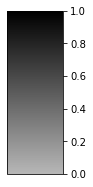

In [256]:
ofile = '{}_{}_major_isos.bed'.format(gene.lower(), obs_condition)
df = gtf_to_bed12(sg, 'sample', obs_condition, tids, gtf, ofile)

In [258]:
ca.triplets.loc[(ca.triplets.source=='sample_major')&(ca.triplets['sample']==obs_condition)&(ca.triplets.gname==gene)]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
210041,sample_major,ENSG00000102974,4.0,1.0,4.0,4.0,1.6,CTCF,vessels,19.757177


In [235]:
# get bed file of all used CTCF promoters
df = df[['Name']] 
df = add_feat(df, kind='tss', col='Name')

In [213]:
ca = cerberus.read(c_annot)

In [236]:
tss = ca.tss.loc[ca.tss.Name.isin(df.tss.unique().tolist())]
tss = tss[['Chromosome', 'Start', 'End', 'Strand', 'Name']]
tss['Score'] = 0
tss = tss[['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand']]

In [237]:
ofile = '{}_{}_tss.bed'.format(gene.lower(), obs_condition)
print(ofile)

ctcf_vessels_tss.bed


In [243]:
# write header line and save
color = get_feat_colors()[0]['tss']
color = color[1:] # remove hash
r,g,b = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
color = '{},{},{}'.format(r,g,b)
print(color)

t_name = 'TSSs from major isoforms of {}'.format(obs_condition)
header = 'track name="{}" visibility=2 color={}\n'.format(t_name, color)
with open(ofile, 'w') as o:
    o.write(header)

86,180,233


In [244]:
tss.to_csv(ofile, sep='\t', index=False, header=False, mode='a')

In [246]:
ca.triplets.loc[(ca.triplets.gname=='ELN')&(ca.triplets.source=='sample_major')&(ca.triplets['sample']=='vessels')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
208438,sample_major,ENSG00000049540,3.0,6.0,26.0,37.0,5.777778,ELN,vessels,427.713043


In [247]:
ca.triplets.loc[(ca.triplets.gname=='CTCF')&(ca.triplets.source=='sample_major')&(ca.triplets['sample']=='vessels')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
210041,sample_major,ENSG00000102974,4.0,1.0,4.0,4.0,1.6,CTCF,vessels,19.757177


In [127]:
gene = 'ELN'
sample = 'vessels'
tids, gtf = get_gene_major_iso_gtf(gene, gtf, major_set, sample=sample)

Found 37 isoforms
grep -E 'ENSG00000049540\[1,2,3\]|ENSG00000049540\[1,76,3\]|ENSG00000049540\[1,1,3\]|ENSG00000049540\[1,8,3\]|ENSG00000049540\[1,76,1\]|ENSG00000049540\[1,2,1\]|ENSG00000049540\[1,1,1\]|ENSG00000049540\[1,8,1\]|ENSG00000049540\[1,147,3\]|ENSG00000049540\[1,14,3\]|ENSG00000049540\[1,149,3\]|ENSG00000049540\[1,108,3\]|ENSG00000049540\[1,3,3\]|ENSG00000049540\[1,98,1\]|ENSG00000049540\[1,135,3\]|ENSG00000049540\[1,107,3\]|ENSG00000049540\[1,112,3\]|ENSG00000049540\[6,33,13\]|ENSG00000049540\[1,136,1\]|ENSG00000049540\[1,147,1\]|ENSG00000049540\[1,18,7\]|ENSG00000049540\[1,96,3\]|ENSG00000049540\[1,111,3\]|ENSG00000049540\[1,108,1\]|ENSG00000049540\[1,36,3\]|ENSG00000049540\[1,127,3\]|ENSG00000049540\[1,111,1\]|ENSG00000049540\[1,136,3\]|ENSG00000049540\[1,103,3\]|ENSG00000049540\[1,97,1\]|ENSG00000049540\[1,96,1\]|ENSG00000049540\[1,77,1\]|ENSG00000049540\[1,59,3\]|ENSG00000049540\[1,4,3\]|ENSG00000049540\[2,2,2\]|ENSG00000049540\[1,97,3\]|ENSG00000049540\[1,17,6\]' ctcf

In [128]:
ofile = '{}_{}_major_isos.bed'.format(gene.lower(), sample)
df = gtf_to_bed12(sg, 'sample', sample, tids, gtf, ofile)

  Chromosome     Start       End                      Name      Score Strand  \
0       chr7  74028050  74069728    ENSG00000049540[1,2,3]  60.760303      +   
0       chr7  74028050  74069728    ENSG00000049540[1,1,3]  43.177643      +   
0       chr7  74028050  74069728   ENSG00000049540[1,76,3]  39.778652      +   
0       chr7  74028050  74069728    ENSG00000049540[1,8,3]  35.264694      +   
0       chr7  74028050  74069957    ENSG00000049540[1,2,1]  23.386642      +   
0       chr7  74028050  74069957    ENSG00000049540[1,1,1]  19.494343      +   
0       chr7  74028050  74069957   ENSG00000049540[1,76,1]  17.654505      +   
0       chr7  74028050  74069957    ENSG00000049540[1,8,1]  11.774277      +   
0       chr7  74028050  74069728   ENSG00000049540[1,14,3]   6.237474      +   
0       chr7  74028050  74069728  ENSG00000049540[1,108,3]   6.014239      +   
0       chr7  74028050  74069728  ENSG00000049540[1,147,3]   4.104070      +   
0       chr7  74028050  74069728  ENSG00

## Can I just use swan??

In [194]:
def get_gene_major_isos(gene, gtf, major_set, sample=None):
    if not sample:
        ofile = '{}_major_isos.gtf'.format(gene.lower())
    elif sample:
        ofile = '{}_{}_major_isos.gtf'.format(gene.lower(), sample)
    df = pd.read_csv(major_set, sep='\t')
    df = df.loc[df.gname == gene]
    if sample:
        df = df.loc[df['sample'] == sample]
    tids = df.tid.unique().tolist()
    return tids

In [199]:
gene = 'ELN'
sample = 'vessels'
obs_col = 'sample'

In [200]:
df = pd.read_csv(major_set, sep='\t')

In [201]:
df = df.loc[df.gname == gene]
df = df.loc[df[obs_col] == sample]

In [202]:
# get tpm df
tpm_df = swan.calc_tpm(sg.adata, obs_col=obs_col).sparse.to_dense()
tpm_df = tpm_df.transpose()
tpm_df = tpm_df.loc[tids, sample]

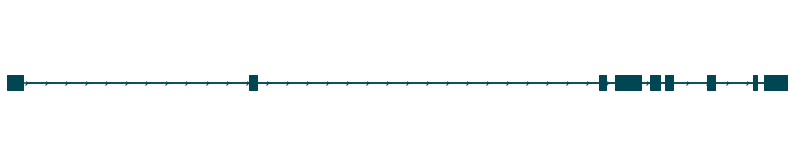

In [193]:
sg.plot_transcript_path(tids[0], browser=True)

In [188]:
# df = pd.read_csv(filt_ab, sep='\t')
# df, tids = get_tpm_table(df,
#                how='iso',
#                min_tpm=1,
#                gene_subset='polya',
#                h5=h5)

# df = df.transpose()
# df.reset_index(inplace=True)
# df.rename({'index':'dataset'}, axis=1, inplace=True)
# df['biosample'] = df.dataset.str.rsplit('_', n=2, expand=True)[0]
# meta = get_tissue_metadata()[['tissue', 'biosample']]
# df = df.merge(meta, how='left', on='biosample')

In [189]:
# df = df.loc[df.tissue=='vessels']
# df.set_index('dataset', inplace=True)
# df = df[[c for c in df.columns if 'ENSG00000049540' in c]]
# df = df.transpose()
# df.head()
# df['sumbert'] = df.sum(axis=1)
# 2.41843/4 # dividing expression of ENSG00000049540[1,77,1] by averaging
# df = df.loc[df.sumbert != 0]
# df = df.sort_values(by='sumbert', ascending=False)
# df

In [190]:
# df.sumbert.tolist()